# <a id='toc1_'></a>[深層学習ノートブック-14 学習済みモデルの保存とロード](#toc0_)
学習を終えたモデルを保存することで、他人に共有したり、システムに組み込んで実用化することが出来る。  
保存するモデルとしては、学習曲線における検証データの損失が最も小さいモデルを保存するのが一般的。  
このモデルの選定にはEaly Stoppingを用いると効率的。

参考：  
* [Udemy講座：「①米国AI開発者がやさしく教える深層学習超入門第一弾【Pythonで実践】」](https://www.udemy.com/course/deeplearning1/learn/lecture/40143418)

## ■ early stopping
学習を途中で止め、過学習を防ぐ正則化手法の一つ。  
検証データに対する損失は学習を進めすぎると、あるepochから劣化し始める（過学習）ので、  
適当な回数のepochで損失がそれより下がらなければ学習を終えるのが良い。  
すなわち、各epochの終了時に学習データと検証データの両方で評価し、検証データにおける損失が一定のepoch数で減少しなかったら学習をストップする。  

In [137]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [76]:
class MLP_1(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        # 親クラスのinitを呼び出す。
        super().__init__()
        # nn.Flattenにより[b, c, h, w] -> [b, c x h x w]（ミニバッチサイズ, 画像の特徴量数の積）に変換
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(num_in, num_hidden)
        self.linear_2 = nn.Linear(num_hidden, num_out)

    # nn.Moduleにもforwardメソッドがあり、ここでオーバーライドしている。
    def forward(self, x):
        # 最初の全結合層の計算に渡す際にnn.Flattenを実行しておく必要あり。
        z = self.linear_2( F.relu( self.linear_1(self.flatten(x))) )
        return z
    

class MyDataset(Dataset):
    def __init__(self, X, y, transform=None) -> None:
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self): #lenを適用したときの挙動を定義
        return len(self.X)
    
    def __getitem__(self, idx): #indexingしたときの挙動
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)
        
        return X, y

In [77]:
# バッチサイズを定義。今回は１ミニバッチ＝３２データとする
batch_size = 32

# データ読み込み。8x8のMNISTデータセットをカスタムデータセットとして読み込む。（練習のため）
dataset = datasets.load_digits()
X = dataset['images'] # 0~16の値をもつ
X = ( X * (255. / 16.) ).astype(np.uint8) # 下記補足参照
y = dataset['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
transform = transforms.Compose([
    transforms.ToTensor(), # 0~255 -> 0~1
    transforms.Normalize((0.5,), (0.5)) # 0~1 -> -1~1
])

# Datasetとして読み込み
train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=10, num_workers=2)

# モデルのコンストラクタに渡す引数を定義。
num_in = 64
num_hidden = 30
num_out = 10

# モデル定義（２層のMLP）
MLP_model = MLP_1(num_in=num_in, num_hidden=num_hidden, num_out=num_out)

# requires_grad_をTrueに設定。最後に_がつくのは設定するという意味。
MLP_model.requires_grad_(True)

# torch.optimを使ってOptimizerを定義
optimizer = optim.SGD(MLP_model.parameters(), lr=0.03)

※torchvision.datasets.MNIST（28x28）の方のMNISTデータセットはサイズが大きく、学習に時間がかかるので、  
　ここでは簡単のためにdatasets.load_digitsの方のMNISTデータセット（8x8）を用いている。  

In [78]:
# MLPの学習ループを関数化
def mlp_learning_loop(MLP_model, train_loader, val_loader, optim, loss_func, epoch=10, early_stopping=None):
    '''
    MLP_model: 任意のMLPモデル
    train_loader: 学習データのDataLoader
    val_loader: 検証データのDataLoader
    optim: optimizer
    loss_func: 損失関数
    epoch: epoch数。デフォルトは10。
    early_stopping: early_stopping判定の際のepoch数。デフォルトはearly_stoppingしない。
    '''

    # 学習・検証結果格納用辞書
    train_results = {}

    # early_stoppingの判定用のカウンターとそのepoch時点での最小の損失を記録する用変数。初期値は無限大を指定。
    early_stopping_counter = 0 
    min_Loss_val = float('inf') # infinity

    for i, _ in enumerate(range(epoch)):

        # 各バッチでの学習データと検証データに対するloss、accuracyを累積する用の変数
        cum_loss = 0
        cum_loss_val = 0
        cum_accuracy_val = 0

        for num_batches, train_data in enumerate(train_loader):
            # 学習データ定義
            X_train_batch, y_train_batch = train_data

            # 順伝播の計算
            y_pred = MLP_model(X_train_batch)
            loss = loss_func(y_pred , y_train_batch)
            cum_loss += loss.item()
            
            # 逆伝播の計算、パラメタ更新
            loss.backward()
            optim.step()
            optim.zero_grad()


        # 検証データに対する損失を計算。こちらもバッチ単位で評価するように変更。（検証データ数が多いときはこの方が効率的）
        with torch.no_grad():
            for num_batches_val, val_data in enumerate(val_loader):
                X_val, y_val = val_data
                y_pred_val = MLP_model(X_val)
                loss_val = loss_func(y_pred_val, y_val)
                accuracy_val = ( (torch.argmax(y_pred_val, dim=1) == y_val).sum() / len(y_val) )
                # バッチごとの損失、accuracyを累積
                cum_loss_val += loss_val.item()
                cum_accuracy_val += accuracy_val.item()


        # 損失、accuracyを記録。
        # DataLoaderからのイテレーションの数＋１が実際のミニバッチ数になるので、累積した損失等をこれで割ってepochごとに計算
        train_results[f"epoch_{i}"] = {
            "Loss_train": cum_loss / (num_batches + 1),
            "Loss_val": cum_loss_val / (num_batches_val + 1),
            "Accuracy": cum_accuracy_val / (num_batches_val + 1),
        }

        print(f'epoch_{i}: {train_results[f"epoch_{i}"]}')


        if early_stopping:
            # i番目のepochの損失がその時点の最小の損失よりも大きい場合、early_stoppingのカウンターを1増やす。
            # そうでない場合、最小の損失値を更新し、カウンターを0に戻す。(暫定チャンピオン方式)
            if train_results[f"epoch_{i}"]["Loss_val"] >= min_Loss_val:
                early_stopping_counter += 1
            else:
                min_Loss_val = train_results[f"epoch_{i}"]["Loss_val"]
                epoch_min_Loss_val = i
                early_stopping_counter = 0
            
            if early_stopping_counter >= early_stopping:
                print("early stoppingにより学習を終了します。")
                print(f"検証データに対する損失が最小となるepoch: {epoch_min_Loss_val}")
                break


    return train_results


In [79]:
# 学習ループ実行
result = mlp_learning_loop(MLP_model, train_loader, val_loader, optimizer, F.cross_entropy, epoch=100, early_stopping=10)

epoch_0: {'Loss_train': 1.8538521776596706, 'Loss_val': 1.267676305439737, 'Accuracy': 0.8027777754598193}
epoch_1: {'Loss_train': 0.8713603516419729, 'Loss_val': 0.5765743346677886, 'Accuracy': 0.8916666573948331}
epoch_2: {'Loss_train': 0.4603702551167872, 'Loss_val': 0.33999547279543346, 'Accuracy': 0.916666661699613}
epoch_3: {'Loss_train': 0.31454841140657663, 'Loss_val': 0.2623278707679775, 'Accuracy': 0.9249999937083986}
epoch_4: {'Loss_train': 0.24678232637234032, 'Loss_val': 0.22033159103658465, 'Accuracy': 0.9416666593816545}
epoch_5: {'Loss_train': 0.20694286479718155, 'Loss_val': 0.19046625143123996, 'Accuracy': 0.9472222146060731}
epoch_6: {'Loss_train': 0.17851547618758762, 'Loss_val': 0.16301943765332302, 'Accuracy': 0.955555549926228}
epoch_7: {'Loss_train': 0.15976522588688466, 'Loss_val': 0.15799811285816961, 'Accuracy': 0.9472222146060731}
epoch_8: {'Loss_train': 0.14343565094491673, 'Loss_val': 0.14299924562995633, 'Accuracy': 0.955555549926228}
epoch_9: {'Loss_trai

想定通りにearly stoppingが行われていることが分かる。

### <a id='toc1_3_1_'></a>[●学習曲線の描画](#toc0_)
学習データと検証データでの損失の推移を確認してみる。

In [80]:
loss_per_epoch_train = []
loss_per_epoch_val = []

for result in result.values():
    loss_per_epoch_train.append(result['Loss_train'])
    loss_per_epoch_val.append(result['Loss_val'])

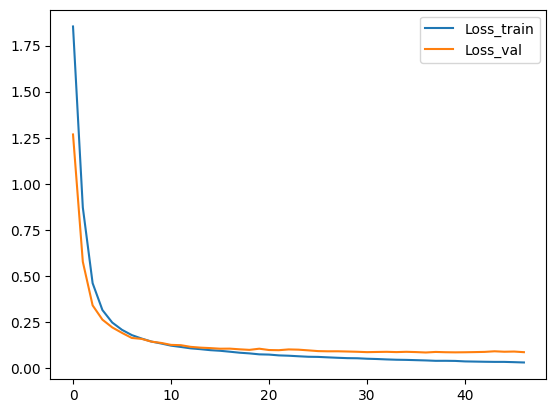

In [81]:
plt.plot(loss_per_epoch_train, label="Loss_train")
plt.plot(loss_per_epoch_val, label="Loss_val")
plt.legend()

train,valどちらも損失が下がっていっており、学習が進んでいることが分かる。

## ■ モデルオブジェクトの保存とロード
* torch.save(): モデルを指定したパスに保存する
    * obj引数: 保存するモデルオブジェクト
    * f引数: モデルの保存先を指定
* torch.load(): 指定したパスからモデルをロードする
    * f引数: ロードするモデルのファイル名やパス
* 拡張子に‘.pth’を使う慣習がある
* 異なる環境でロードした際に予期しない問題が起こる可能性があることに注意

In [83]:
MLP_model

MLP_1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=64, out_features=30, bias=True)
  (linear_2): Linear(in_features=30, out_features=10, bias=True)
)

In [82]:
# 上記で学習済みのMLPモデルを"sample_model.pth"として保存
torch.save(MLP_model, 'sample_model.pth')

In [86]:
# 保存したモデルを別のモデルオブジェクトとして読み込む
loaded_model = torch.load('sample_model.pth')

In [87]:
loaded_model

MLP_1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=64, out_features=30, bias=True)
  (linear_2): Linear(in_features=30, out_features=10, bias=True)
)

同様の層数、ノード数のモデルとして読み込まれていることが分かる。

## ■ モデルのパラメータの保存とロード
* モデルオブジェクトそのものではなく、学習の結果定まった $\textbf{W}, \textbf{B}$を保存し、ロードして利用する。
* パラメータのみを切り出して保存することで，パラメータに関連するコード以外が変更されてもロードして使用できるため、  
オブジェクトごとの保存/ロードするより一般に推奨される
* モデルオブジェクトの.state_dict()でモデルのパラメータの情報のみを取り出す
* Opbmizerについて同様にパラメータを保存することができる

In [88]:
# モデルのパラメタ確認
MLP_model.state_dict()

OrderedDict([('linear_1.weight',
              tensor([[ 0.0099,  0.0349,  0.0222,  ...,  0.1807,  0.2009, -0.0766],
                      [-0.1395, -0.0772, -0.1397,  ..., -0.0218, -0.0959, -0.1533],
                      [-0.1792, -0.1058, -0.1075,  ..., -0.4447, -0.2377, -0.1605],
                      ...,
                      [ 0.1176, -0.0163,  0.0474,  ..., -0.1015, -0.0992,  0.0771],
                      [-0.1451,  0.0351, -0.1060,  ...,  0.1092,  0.1848,  0.0138],
                      [ 0.0689,  0.0063,  0.2765,  ..., -0.2749, -0.2611, -0.1532]])),
             ('linear_1.bias',
              tensor([ 0.1612,  0.0698, -0.0483, -0.0667,  0.0847,  0.0207,  0.0979,  0.1577,
                       0.0645,  0.0949,  0.1516, -0.0631,  0.0356,  0.1133,  0.1539,  0.1727,
                       0.1652, -0.0275, -0.0008,  0.0173,  0.0761,  0.0372,  0.0104,  0.0456,
                      -0.0498, -0.0434,  0.1395, -0.0629, -0.0127,  0.1367])),
             ('linear_2.weight',
        

In [90]:
MLP_model

MLP_1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=64, out_features=30, bias=True)
  (linear_2): Linear(in_features=30, out_features=10, bias=True)
)

In [89]:
# パラメタ保存
torch.save(MLP_model.state_dict(), 'sample_model_state_dict.pth')

In [91]:
# パラメタ読み込み前に、パラメタを読み込ませたいモデルオブジェクトを作成しておく必要あり。
another_model = MLP_1(64, 30, 10)

# パラメタ読み込み。読み込む際はload_state_dictメソッドを用いる
another_model.load_state_dict(torch.load('sample_model_state_dict.pth'))

<All keys matched successfully>

In [92]:
another_model.state_dict()

OrderedDict([('linear_1.weight',
              tensor([[ 0.0099,  0.0349,  0.0222,  ...,  0.1807,  0.2009, -0.0766],
                      [-0.1395, -0.0772, -0.1397,  ..., -0.0218, -0.0959, -0.1533],
                      [-0.1792, -0.1058, -0.1075,  ..., -0.4447, -0.2377, -0.1605],
                      ...,
                      [ 0.1176, -0.0163,  0.0474,  ..., -0.1015, -0.0992,  0.0771],
                      [-0.1451,  0.0351, -0.1060,  ...,  0.1092,  0.1848,  0.0138],
                      [ 0.0689,  0.0063,  0.2765,  ..., -0.2749, -0.2611, -0.1532]])),
             ('linear_1.bias',
              tensor([ 0.1612,  0.0698, -0.0483, -0.0667,  0.0847,  0.0207,  0.0979,  0.1577,
                       0.0645,  0.0949,  0.1516, -0.0631,  0.0356,  0.1133,  0.1539,  0.1727,
                       0.1652, -0.0275, -0.0008,  0.0173,  0.0761,  0.0372,  0.0104,  0.0456,
                      -0.0498, -0.0434,  0.1395, -0.0629, -0.0127,  0.1367])),
             ('linear_2.weight',
        

同じパラメタが読み込まれていることが分かる。

## ■ 学習ループ中に最良のモデルを保存する
early stoppingから得られた最もvalidation lossが低いモデルを保存するようにする。  
→モデルのパラメータ、Optimizerのパラメータ、当該epochにおけるvalidation lossをdictionary形式で保存する。

In [116]:
# バッチサイズを定義。今回は１ミニバッチ＝３２データとする
batch_size = 32

# データ読み込み。8x8のMNISTデータセットをカスタムデータセットとして読み込む。（練習のため）
dataset = datasets.load_digits()
X = dataset['images'] # 0~16の値をもつ
X = ( X * (255. / 16.) ).astype(np.uint8) # 下記補足参照
y = dataset['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
transform = transforms.Compose([
    transforms.ToTensor(), # 0~255 -> 0~1
    transforms.Normalize((0.5,), (0.5)) # 0~1 -> -1~1
])

# Datasetとして読み込み
train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=10, num_workers=2)

# モデルのコンストラクタに渡す引数を定義。
num_in = 64
num_hidden = 30
num_out = 10

# モデル定義（２層のMLP）
MLP_model = MLP_1(num_in=num_in, num_hidden=num_hidden, num_out=num_out)

# requires_grad_をTrueに設定。最後に_がつくのは設定するという意味。
MLP_model.requires_grad_(True)

# torch.optimを使ってOptimizerを定義
optimizer = optim.SGD(MLP_model.parameters(), lr=0.03)

In [117]:
# MLPの学習ループを関数化
def mlp_learning_loop(MLP_model, train_loader, val_loader, optim, loss_func, epoch=10, early_stopping=None, save_path=None):
    '''
    MLP_model: 任意のMLPモデル
    train_loader: 学習データのDataLoader
    val_loader: 検証データのDataLoader
    optim: optimizer
    loss_func: 損失関数
    epoch: epoch数。デフォルトは10。
    early_stopping: early_stopping判定の際のepoch数。デフォルトはearly_stoppingしない。
    '''

    # 学習・検証結果格納用辞書
    train_results = {}

    # early_stoppingの判定用のカウンターとそのepoch時点での最小の損失を記録する用変数。初期値は無限大を指定。
    early_stopping_counter = 0 
    min_Loss_val = float('inf') # infinity

    for i, _ in enumerate(range(epoch)):

        # 各バッチでの学習データと検証データに対するloss、accuracyを累積する用の変数
        cum_loss = 0
        cum_loss_val = 0
        cum_accuracy_val = 0

        for num_batches, train_data in enumerate(train_loader):
            # 学習データ定義
            X_train_batch, y_train_batch = train_data

            # 順伝播の計算
            y_pred = MLP_model(X_train_batch)
            loss = loss_func(y_pred , y_train_batch)
            cum_loss += loss.item()
            
            # 逆伝播の計算、パラメタ更新
            loss.backward()
            optim.step()
            optim.zero_grad()


        # 検証データに対する損失を計算。こちらもバッチ単位で評価するように変更。（検証データ数が多いときはこの方が効率的）
        with torch.no_grad():
            for num_batches_val, val_data in enumerate(val_loader):
                X_val, y_val = val_data
                y_pred_val = MLP_model(X_val)
                loss_val = loss_func(y_pred_val, y_val)
                accuracy_val = ( (torch.argmax(y_pred_val, dim=1) == y_val).sum() / len(y_val) )
                # バッチごとの損失、accuracyを累積
                cum_loss_val += loss_val.item()
                cum_accuracy_val += accuracy_val.item()


        # 損失、accuracyを記録。
        # DataLoaderからのイテレーションの数＋１が実際のミニバッチ数になるので、累積した損失等をこれで割ってepochごとに計算
        train_results[f"epoch_{i}"] = {
            "Loss_train": cum_loss / (num_batches + 1),
            "Loss_val": cum_loss_val / (num_batches_val + 1),
            "Accuracy": cum_accuracy_val / (num_batches_val + 1),
        }

        print(f'epoch_{i}: {train_results[f"epoch_{i}"]}')


        if early_stopping:
            # i番目のepochの損失がその時点の最小の損失よりも大きい場合、early_stoppingのカウンターを1増やす。
            # そうでない場合、最小の損失値を更新し、カウンターを0に戻す。(暫定チャンピオン方式)
            if train_results[f"epoch_{i}"]["Loss_val"] >= min_Loss_val:
                early_stopping_counter += 1
            else:
                min_Loss_val = train_results[f"epoch_{i}"]["Loss_val"]
                epoch_min_Loss_val = i
                early_stopping_counter = 0

                # save_pathがNoneではなければ保存する
                # 改善されていれば以下の辞書を更新する
                if save_path:
                    best_params_and_Loss = {
                        "epoch": epoch_min_Loss_val,
                        "Model_param": MLP_model.state_dict(),
                        "Optimizer_param": optim.state_dict(),
                        "Loss_val": min_Loss_val
                    }
            
            if early_stopping_counter >= early_stopping:
                print("early stoppingにより学習を終了します。")
                print(f"検証データに対する損失が最小となるepoch: {epoch_min_Loss_val}")
                break


    # save_pathに最良結果の各種パラメタを保存する。※補足１
    torch.save(best_params_and_Loss, save_path)

    return train_results, best_params_and_Loss


※補足１：torch.saveはpythonのオブジェクトを保存するメソッドなので、モデルに限らず色々保存できる。  
　ファイルに出力するところはループのところで実行すると処理時間が劣化するので、最後に一回出力すれば十分

In [118]:
# 学習ループ実行
_, params_result = mlp_learning_loop(MLP_model, train_loader, val_loader, optimizer, F.cross_entropy, epoch=100, early_stopping=10, save_path="MLP_result.pth")

epoch_0: {'Loss_train': 1.9596559421883688, 'Loss_val': 1.4145205716292064, 'Accuracy': 0.7444444418781333}
epoch_1: {'Loss_train': 0.943395180006822, 'Loss_val': 0.6018292696939574, 'Accuracy': 0.8999999910593033}
epoch_2: {'Loss_train': 0.4765450304581059, 'Loss_val': 0.3674698898361789, 'Accuracy': 0.9222222136126624}
epoch_3: {'Loss_train': 0.3244988319153587, 'Loss_val': 0.2737314845952723, 'Accuracy': 0.9333333240614997}
epoch_4: {'Loss_train': 0.2525691797491163, 'Loss_val': 0.22340893869598707, 'Accuracy': 0.9444444361660216}
epoch_5: {'Loss_train': 0.20892196622056267, 'Loss_val': 0.1917779922692312, 'Accuracy': 0.9499999913904402}
epoch_6: {'Loss_train': 0.1808038928817647, 'Loss_val': 0.1736045569802324, 'Accuracy': 0.958333326710595}
epoch_7: {'Loss_train': 0.1624720163203569, 'Loss_val': 0.16769810802199775, 'Accuracy': 0.9499999913904402}
epoch_8: {'Loss_train': 0.14477047172840685, 'Loss_val': 0.15440016001876858, 'Accuracy': 0.958333326710595}
epoch_9: {'Loss_train': 0.

In [120]:
params_result

{'epoch': 56,
 'Model_param': OrderedDict([('linear_1.weight',
               tensor([[ 0.0700, -0.1004, -0.0958,  ...,  0.0803, -0.0952, -0.1111],
                       [-0.0217, -0.0034,  0.0641,  ...,  0.1084, -0.2026,  0.0524],
                       [-0.0530, -0.1565,  0.0017,  ..., -0.1727, -0.1910,  0.0113],
                       ...,
                       [ 0.0813, -0.1134, -0.1322,  ...,  0.0519,  0.1667, -0.0923],
                       [ 0.0108, -0.0275,  0.0612,  ..., -0.1205,  0.0746, -0.1491],
                       [-0.0228,  0.1435, -0.0761,  ...,  0.2858,  0.0682,  0.0191]])),
              ('linear_1.bias',
               tensor([-0.0830, -0.0070,  0.1434,  0.0112,  0.1515, -0.0662,  0.1211,  0.1132,
                        0.0921,  0.1135,  0.1095, -0.0668,  0.0727,  0.0342, -0.0567, -0.0048,
                        0.1008,  0.0768, -0.0148,  0.1612,  0.1404,  0.1004,  0.0127,  0.0010,
                       -0.0450,  0.0162, -0.0276,  0.1602,  0.1638, -0.0307])),

In [128]:
# torch.loadはモデルのパラメタ等以外も読み込める。
torch.load('MLP_result.pth')

{'epoch': 56,
 'Model_param': OrderedDict([('linear_1.weight',
               tensor([[ 0.0700, -0.1004, -0.0958,  ...,  0.0803, -0.0952, -0.1111],
                       [-0.0217, -0.0034,  0.0641,  ...,  0.1084, -0.2026,  0.0524],
                       [-0.0530, -0.1565,  0.0017,  ..., -0.1727, -0.1910,  0.0113],
                       ...,
                       [ 0.0813, -0.1134, -0.1322,  ...,  0.0519,  0.1667, -0.0923],
                       [ 0.0108, -0.0275,  0.0612,  ..., -0.1205,  0.0746, -0.1491],
                       [-0.0228,  0.1435, -0.0761,  ...,  0.2858,  0.0682,  0.0191]])),
              ('linear_1.bias',
               tensor([-0.0830, -0.0070,  0.1434,  0.0112,  0.1515, -0.0662,  0.1211,  0.1132,
                        0.0921,  0.1135,  0.1095, -0.0668,  0.0727,  0.0342, -0.0567, -0.0048,
                        0.1008,  0.0768, -0.0148,  0.1612,  0.1404,  0.1004,  0.0127,  0.0010,
                       -0.0450,  0.0162, -0.0276,  0.1602,  0.1638, -0.0307])),

In [129]:
params_result['Optimizer_param']

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.03,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1, 2, 3]}]}

In [133]:
# 実際に別モデルでパラメタ読み込み
state = torch.load('MLP_result.pth')
another_model = MLP_1(64, 30, 10)

# パラメタ読み込み。読み込む際はload_state_dictメソッドを用いる。stateは辞書型であることに注意
another_model.load_state_dict(state['Model_param'])

<All keys matched successfully>

In [135]:
another_model.state_dict()

OrderedDict([('linear_1.weight',
              tensor([[ 0.0700, -0.1004, -0.0958,  ...,  0.0803, -0.0952, -0.1111],
                      [-0.0217, -0.0034,  0.0641,  ...,  0.1084, -0.2026,  0.0524],
                      [-0.0530, -0.1565,  0.0017,  ..., -0.1727, -0.1910,  0.0113],
                      ...,
                      [ 0.0813, -0.1134, -0.1322,  ...,  0.0519,  0.1667, -0.0923],
                      [ 0.0108, -0.0275,  0.0612,  ..., -0.1205,  0.0746, -0.1491],
                      [-0.0228,  0.1435, -0.0761,  ...,  0.2858,  0.0682,  0.0191]])),
             ('linear_1.bias',
              tensor([-0.0830, -0.0070,  0.1434,  0.0112,  0.1515, -0.0662,  0.1211,  0.1132,
                       0.0921,  0.1135,  0.1095, -0.0668,  0.0727,  0.0342, -0.0567, -0.0048,
                       0.1008,  0.0768, -0.0148,  0.1612,  0.1404,  0.1004,  0.0127,  0.0010,
                      -0.0450,  0.0162, -0.0276,  0.1602,  0.1638, -0.0307])),
             ('linear_2.weight',
        